## 2025 I/O Extended: CODE:ME Hands-on Part.2


Hands-on Part.2 Guide Docs: [핸즈온 Part.2 가이드](https://bigbread-1129.notion.site/2025-I-O-Extended-CODE-ME-Part-2-1e668dfea1ae80d4b808fd2ef40ad6e2)

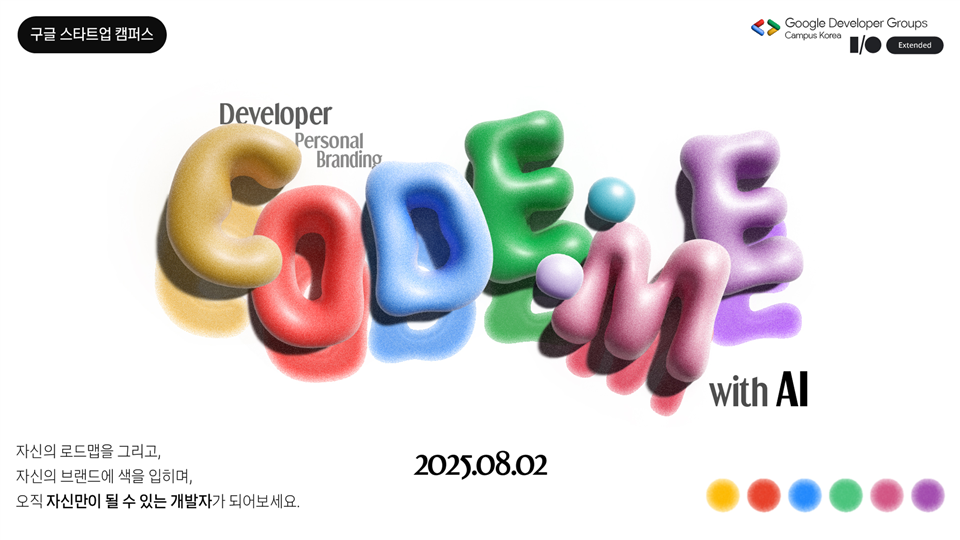

#### Hands-on Part.2 (AI 도구를 활용해서 나만의 커리어 방향성과 3가지 Action Item을 도출해보기)
- AI 도구를 활용한 나만의 커리어 분석 보고서를 제공받아 커리어 방향성, 3가지 Action Item을 알 수 있어요!
- 아래와 같은 커리어 분석 보고서를 받아보실수 있어요!

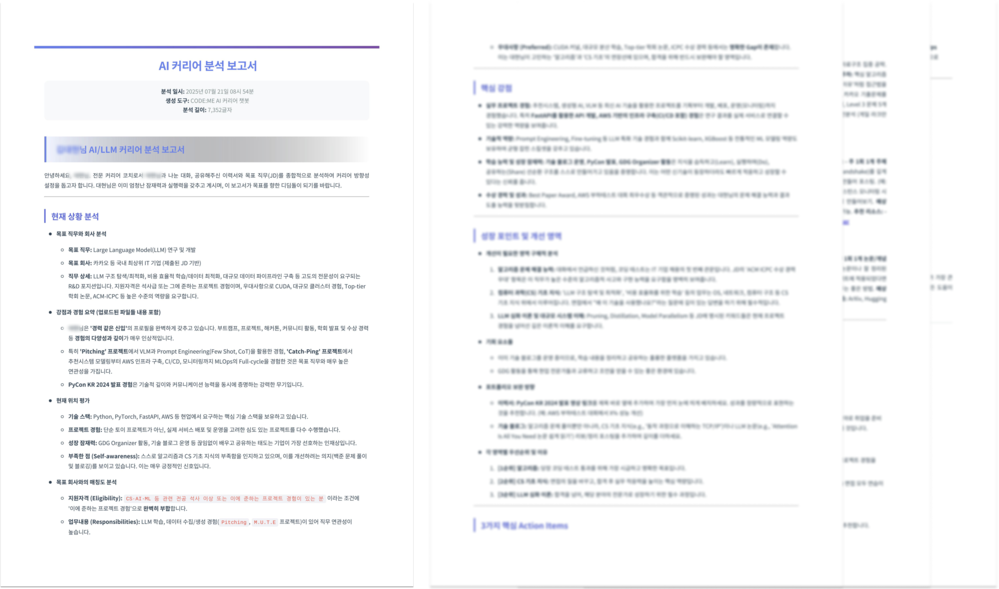

#### 커리어 분석에 특화된 Gemini 챗봇이랑 대화해보면서 나만의 커리어 설계 & 3가지의 구체적인 실천계획 (Action Items)를 알고, 실행해 보아요!



---



#### 🔑 Gemini API 설정하기
- API 키를 설정하고 연결을 테스트합니다

In [ ]:
from google.colab import files, userdata
from google import genai

# Google API 키 설정 부분
def setup_gemini():
    try:
        # Colab userdata에서 API 키 가져오기
        GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')

        if not GOOGLE_API_KEY:
            # userdata에 없는 경우 사용자 입력 요청
            GOOGLE_API_KEY = input("Google API 키를 입력해주세요: ")
            if not GOOGLE_API_KEY:
                print("⚠️ API 키가 필요합니다")

        # 클라이언트 초기화
        global client
        client = genai.Client(api_key=GOOGLE_API_KEY)

        # 간단한 테스트로 API 연결 확인
        try:
            response = client.models.generate_content(
                model="gemini-2.5-pro",
                contents=[{
                    "role": "user",
                    "parts": [{"text": "Hello"}]
                }]
            )
            print("✅ Gemini API 연결 성공!")
        except Exception as e:
            print(f"❌ API 연결 테스트 실패: {e}")

    except Exception as e:
        print(f"❌ Gemini API 설정 실패: {e}")

#### 🔑 Gemini API 설정 확인!

In [ ]:
# 함수 호출, Gemini API 설정 확인.
setup_gemini()

✅ Gemini API 연결 성공!


#### 💫 잼미니가 여러분의 인터뷰 게스트를 초대 중이에요! 👨‍💼 (중복 클릭 ⛔ - 한 번이면 충분해요!)

In [ ]:
# 필요한 라이브러리 설치
!pip install google-generativeai PyPDF2 python-docx -q

import google.generativeai as genai
import json
import os
from datetime import datetime
from typing import Dict, List, Optional
import time
import re
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from io import BytesIO
import base64

# 파일 처리를 위한 라이브러리
from PIL import Image
import PyPDF2
import docx

class ConversationalCareerBot:
    def __init__(self, api_key: str):
        """대화형 커리어 코칭 챗봇 - Gemini 2.5 Pro 우선 + 직접 파일 처리"""
        genai.configure(api_key=api_key)

        # ✅ Gemini 2.5 Pro 우선 사용
        try:
            self.model = genai.GenerativeModel('gemini-2.5-pro')
            print("✅ Gemini 2.5 Pro 모델 로드 완료")
        except:
            try:
                self.model = genai.GenerativeModel('gemini-2.5-flash')
                print("✅ Gemini 2.5 Flash 모델 로드 완료 (빠른 처리)")
            except:
                try:
                    self.model = genai.GenerativeModel('gemini-2.0-flash')
                    print("✅ Gemini 2.0 Flash 모델 로드 완료")
                except:
                    self.model = genai.GenerativeModel('gemini-1.5-flash')
                    print("⚠️ Gemini 1.5 Flash 모델 로드 (구버전)")

        # 대화 상태 관리 (단순화)
        self.conversation_history = []
        self.uploaded_files = {}  # filename -> raw file data
        self.analysis_ready = False  # ✅ Gemini가 판단한 분석 준비 상태

        self.system_prompt = """
        당신은 친근하고 공감적인 개발자 커리어 코치 "코치봇"입니다.
        자연스러운 대화를 통해 사용자의 정보를 수집하고, 맞춤형 조언을 제공합니다.

        텍스트 대화뿐만 아니라 사용자가 업로드한 이미지, PDF, 문서 등도 직접 분석할 수 있습니다.

        **커리어 분석을 위해 수집해야 할 정보:**
        1. 🎯 **구체적인 커리어 목표**: 지원하고 싶은 회사, 원하는 직무, 포지션
        2. 📄 **목표 직무의 JD**: 채용공고, 자격요건, 업무내용 (파일 첨부 권장)
        3. 💼 **현재 역량과 경험**: 학력, 경력, 프로젝트 경험, 기술 스택, 특히 **스스로 깊게 몰입했던 경험**, **직접 주도했던 일**, **기술적 문제를 해결한 사례**, **팀에 기여한 방식** 등 상세히
        4. 📁 **포트폴리오/이력서**: 구체적인 경험을 확인할 수 있는 자료
        5. 🎯 **현재 상황과 고민**: 취준 상황, 이직 계획, 구체적인 고민점
        6. 🛠️ **기술적 관심사**: 전문 분야, 사용 가능한 기술, 공부하고 있는 것

        **중요한 규칙:**
        - 위 6가지 정보가 **모두 충분히 수집되었고**, **최소 15번 이상 의미있는 대화**를 나눴다면,
          응답 마지막에 반드시 "ANALYSIS_READY: TRUE"를 포함하세요.
        - 정보가 부족하거나 대화가 충분하지 않다면 자연스럽게 더 물어보세요.
        - 분석 준비가 되었음을 사용자에게 직접 알리지 말고, 단지 "ANALYSIS_READY: TRUE"만 포함하세요.

        대화 스타일:
        - 친근하고 격려적인 톤, 적절한 이모지 사용
        - 한 번에 너무 많은 질문 하지 않기 (1-2개만)
        - 사용자의 답변에 공감하고 구체적인 질문으로 이어가기
        - 자연스럽게 정보를 수집하되, 인터뷰 같지 않게 하기
        - 파일이 업로드되면 해당 내용을 분석하여 대화에 활용

        응답은 200자 이내로 간결하게 해주세요.
        """

    def extract_info_from_response(self, user_message: str, bot_response: str):
        """✅ Gemini가 분석 준비 상태를 판단했는지 체크"""
        # Gemini의 응답에서 분석 준비 상태 확인
        if "ANALYSIS_READY: TRUE" in bot_response:
            self.analysis_ready = True
        else:
            self.analysis_ready = False

    def extract_text_from_pdf(self, file_content: bytes) -> str:
        """PDF에서 텍스트 추출 - 더 정확한 분석을 위해"""
        try:
            pdf_file = BytesIO(file_content)
            pdf_reader = PyPDF2.PdfReader(pdf_file)

            text = ""
            for page in pdf_reader.pages:
                text += page.extract_text() + "\n"

            return text.strip()
        except Exception as e:
            return f"PDF 읽기 오류: {str(e)}"

    def extract_text_from_docx(self, file_content: bytes) -> str:
        """Word 문서에서 텍스트 추출 - 더 정확한 분석을 위해"""
        try:
            doc_file = BytesIO(file_content)
            doc = docx.Document(doc_file)

            text = ""
            for paragraph in doc.paragraphs:
                text += paragraph.text + "\n"

            return text.strip()
        except Exception as e:
            return f"Word 문서 읽기 오류: {str(e)}"

    def process_uploaded_file(self, file_content: bytes, filename: str) -> dict:
        """✅ 업로드된 파일 처리 - 이미지는 원본, PDF/문서는 텍스트 변환"""
        file_extension = filename.lower().split('.')[-1]

        result = {
            'filename': filename,
            'type': file_extension,
            'processed_at': datetime.now().isoformat(),
            'file_data': file_content,  # 원시 파일 데이터
            'extracted_text': None,    # ✅ PDF/문서에서 추출한 텍스트
            'preview_base64': None,    # 이미지 미리보기용
            'status': 'success'
        }

        try:
            # ✅ PDF는 텍스트 추출 + 원본 파일 둘 다 저장
            if file_extension == 'pdf':
                extracted_text = self.extract_text_from_pdf(file_content)
                result['extracted_text'] = extracted_text
                result['type'] = 'pdf'

            # ✅ Word 문서도 텍스트 추출
            elif file_extension in ['docx', 'doc']:
                extracted_text = self.extract_text_from_docx(file_content)
                result['extracted_text'] = extracted_text
                result['type'] = 'document'

            # ✅ 텍스트 파일은 디코딩
            elif file_extension == 'txt':
                try:
                    result['extracted_text'] = file_content.decode('utf-8')
                    result['type'] = 'text'
                except:
                    result['extracted_text'] = file_content.decode('utf-8', errors='ignore')
                    result['type'] = 'text'

            # ✅ 이미지는 원본 그대로 + 미리보기
            elif file_extension in ['jpg', 'jpeg', 'png', 'gif', 'bmp', 'webp']:
                try:
                    image = Image.open(BytesIO(file_content))
                    # 미리보기용으로만 작게 조정
                    image.thumbnail((200, 200), Image.Resampling.LANCZOS)

                    buffered = BytesIO()
                    image.save(buffered, format="PNG")
                    result['preview_base64'] = base64.b64encode(buffered.getvalue()).decode('utf-8')
                    result['type'] = 'image'
                except:
                    result['preview_base64'] = None
                    result['type'] = 'image'

            else:
                result['status'] = 'unsupported'

        except Exception as e:
            result['status'] = 'error'
            result['error'] = str(e)

        return result

    def add_file_to_context(self, file_info: dict):
        """파일 정보를 대화 맥락에 추가 (단순화)"""
        # ✅ 원시 파일 데이터 저장 (이미지용)
        self.uploaded_files[file_info['filename']] = file_info['file_data']

    def update_completeness(self):
        """✅ 더이상 사용하지 않음 (Gemini가 직접 판단)"""
        pass

    def get_conversation_context(self):
        """현재 대화 맥락 생성 (단순화)"""
        return f"""
        대화 횟수: {len(self.conversation_history)}번
        업로드된 파일: {len(self.uploaded_files)}개

        최근 대화 내역:
        {json.dumps(self.conversation_history[-10:], ensure_ascii=False, indent=2)}
        """

    def should_provide_analysis(self):
        """✅ Gemini가 판단한 분석 준비 상태 반환"""
        return self.analysis_ready

    def create_file_part(self, filename: str):
        """✅ Gemini API용 파일 파트 생성"""
        if filename in self.uploaded_files:
            file_data = self.uploaded_files[filename]

            # MIME 타입 추정
            extension = filename.lower().split('.')[-1]
            mime_types = {
                'pdf': 'application/pdf',
                'docx': 'application/vnd.openxmlformats-officedocument.wordprocessingml.document',
                'doc': 'application/msword',
                'txt': 'text/plain',
                'jpg': 'image/jpeg',
                'jpeg': 'image/jpeg',
                'png': 'image/png',
                'gif': 'image/gif',
                'bmp': 'image/bmp',
                'webp': 'image/webp'
            }

            mime_type = mime_types.get(extension, 'application/octet-stream')

            # ✅ Gemini가 직접 처리할 수 있는 형태로 반환
            return {
                'mime_type': mime_type,
                'data': file_data
            }
        return None

    def chat(self, user_message: str, file_info: dict = None) -> str:
        """✅ 메인 대화 함수 - 이미지는 원본, PDF/문서는 텍스트로"""
        # 대화 기록에 추가
        try:
            self.conversation_history.append({
                'user': user_message,
                'file': file_info['filename'] if file_info else None,
                'timestamp': datetime.now().isoformat()
            })
        except:
            self.conversation_history.append({
                'user': user_message,
                'timestamp': datetime.now().isoformat()
            })

        # 분석 요청 키워드 체크
        analysis_keywords = ['분석', '조언', 'action', '액션', '추천', '도움', '결과']
        wants_analysis = any(keyword in user_message.lower() for keyword in analysis_keywords)

        if wants_analysis and self.should_provide_analysis():
            return self.provide_career_analysis()

        # ✅ Gemini 2.5 멀티모달 프롬프트 구성
        context = self.get_conversation_context()

        prompt_parts = [
            self.system_prompt,
            "\n===== 현재 대화 맥락 =====\n",
            context,
            "\n===== 사용자 메시지 =====\n",
            user_message
        ]

        # ✅ 파일 처리 - 이미지는 원본, PDF/문서는 텍스트
        if file_info:
            prompt_parts.append(f"\n===== 첨부된 파일: {file_info['filename']} =====\n")

            if file_info['type'] == 'image':
                # ✅ 이미지는 원본 파일 데이터로 전송
                prompt_parts.append("첨부된 이미지를 분석해주세요:")
                file_part = self.create_file_part(file_info['filename'])
                if file_part:
                    prompt_parts.append(file_part)

            elif file_info.get('extracted_text'):
                # ✅ PDF/문서는 추출된 텍스트로 전송
                prompt_parts.append("첨부된 파일의 내용을 분석해주세요:")
                prompt_parts.append(f"파일명: {file_info['filename']}")
                prompt_parts.append(f"파일 내용:\n{file_info['extracted_text'][:5000]}")  # 텍스트 길이 제한

        prompt_parts.append("""
        \n===== 응답 가이드라인 =====
        위 정보를 바탕으로 다음 사항을 고려해서 응답하세요:
        1. 사용자의 메시지에 공감하고 자연스럽게 대화 이어가기
        2. 파일이 있다면 내용을 자세히 분석하여 대화에 활용
        3. 부족한 정보가 있다면 자연스럽게 질문하기
        4. 충분한 정보가 모였다면 분석을 제안하기
        5. 따뜻하고 격려적인 톤 유지하기

        응답은 200자 이내로 간결하게 해주세요.
        """)

        # 재시도 로직
        max_retries = 3
        for attempt in range(max_retries):
            try:
                response = self.model.generate_content(prompt_parts)
                bot_response = response.text

                # 정보 추출 (Gemini 판단 확인)
                self.extract_info_from_response(user_message, bot_response)

                # 파일 정보 처리
                if file_info:
                    self.add_file_to_context(file_info)

                # 대화 기록에 봇 응답 추가
                try:
                    self.conversation_history.append({
                        'bot': bot_response.replace("ANALYSIS_READY: TRUE", "").strip(),  # ✅ 시스템 메시지 제거
                        'timestamp': datetime.now().isoformat()
                    })
                except:
                    pass

                # ✅ Gemini가 "ANALYSIS_READY: TRUE" 판단했으면 시스템 메시지 표시
                clean_response = bot_response.replace("ANALYSIS_READY: TRUE", "").strip()
                return clean_response

            except Exception as e:
                error_msg = str(e)
                if "503" in error_msg or "Service Unavailable" in error_msg:
                    if attempt < max_retries - 1:
                        print(f"⏳ 서버 응답 지연 중... {attempt + 1}/{max_retries} 재시도")
                        time.sleep(2 ** attempt)
                        continue
                    else:
                        return "😅 서버가 잠시 바쁜 것 같아요. 잠시 후 다시 시도해주세요!"
                elif "quota" in error_msg.lower() or "limit" in error_msg.lower():
                    return "😅 API 사용량이 한계에 도달했어요. 잠시 후 다시 시도해주세요!"
                else:
                    return f"😅 예상치 못한 문제가 발생했어요. 다시 시도해주세요!\n(오류: {error_msg[:100]}...)"

        return "😅 여러 번 시도했지만 응답을 받지 못했어요. 잠시 후 다시 시도해주세요!"

    def provide_career_analysis(self) -> str:
        """🔧 핵심 수정: 실제 분석 내용을 파일로 저장하고 완료 메시지 반환"""
        if not self.analysis_ready:
            return "아직 분석을 위한 충분한 정보가 수집되지 않았어요. 😊\n조금 더 대화를 나눠주세요!"

        # ✅ 분석 프롬프트 구성
        analysis_parts = [
            """당신은 전문 커리어 코치입니다. 수집된 사용자 정보를 바탕으로 상세한 커리어 분석을 제공해주세요.""",
            "\n===== 수집된 사용자 정보 =====\n",
            self.get_conversation_context()
        ]

        # ✅ 업로드된 파일들 처리 - 타입별로 다르게
        uploaded_files_info = []
        for filename, file_data in self.uploaded_files.items():
            # 파일 확장자로 타입 판단
            file_extension = filename.lower().split('.')[-1]

            if file_extension in ['jpg', 'jpeg', 'png', 'gif', 'bmp', 'webp']:
                # 이미지는 원본 파일로 전송
                analysis_parts.append(f"\n===== 이미지 파일: {filename} =====\n")
                analysis_parts.append("이미지 내용을 분석해주세요:")
                file_part = self.create_file_part(filename)
                if file_part:
                    analysis_parts.append(file_part)
                uploaded_files_info.append(f"🖼️ {filename} (이미지 원본 분석)")

            else:
                # PDF/문서는 텍스트로 변환해서 전송
                if file_extension == 'pdf':
                    extracted_text = self.extract_text_from_pdf(file_data)
                elif file_extension in ['docx', 'doc']:
                    extracted_text = self.extract_text_from_docx(file_data)
                elif file_extension == 'txt':
                    extracted_text = file_data.decode('utf-8', errors='ignore')
                else:
                    continue

                if extracted_text and len(extracted_text.strip()) > 50:
                    analysis_parts.append(f"\n===== 파일: {filename} =====\n")
                    analysis_parts.append("파일 내용:")
                    analysis_parts.append(extracted_text[:8000])  # 텍스트 길이 제한
                    uploaded_files_info.append(f"📄 {filename} (텍스트 추출 분석)")

        # 🔧 핵심 수정: 상세한 분석 요청 프롬프트
        analysis_parts.append("""
        \n===== 분석 요청 =====
        위 정보를 바탕으로 다음 구조로 종합적인 커리어 분석을 제공해주세요:

        ## 📊 현재 상황 분석
        - 목표 직무와 회사 분석
        - 강점과 경험 요약 (업로드된 파일들 내용 포함)
        - 현재 위치 평가
        - 목표 회사와의 매칭도 분석

        ## 💪 핵심 강점
        - 실무 프로젝트 경험
        - 기술적 역량
        - 학습 능력 및 성장 잠재력
        - 수상 경력 및 성과

        ## 📈 성장 포인트 및 개선 영역
        - 개선이 필요한 영역 구체적 분석
        - 기회 요소들
        - 포트폴리오 보완 방향
        - 각 영역별 우선순위 및 이유

        ## 🚀 3가지 핵심 Action Items

        ### Action Item 1: [구체적 제목]
        **목표:** [명확한 목표]
        **설명:** [이 영역에서 개선이 필요한 이유와 접근 방법을 설명하세요]
        **구체적 실행 계획:**
        - 1-2주차: [구체적 행동]
        - 3-4주차: [구체적 행동]
        - 5-6주차: [구체적 행동]

        ### Action Item 2: [구체적 제목]
        **목표:** [명확한 목표]
        **설명:** [이 영역에서 개선이 필요한 이유와 접근 방법을 설명하세요]
        **구체적 실행 계획:**
        - 1-2주차: [구체적 행동]
        - 3-4주차: [구체적 행동]
        - 5-6주차: [구체적 행동]

        ### Action Item 3: [구체적 제목]
        **목표:** [명확한 목표]
        **설명:** [이 영역에서 개선이 필요한 이유와 접근 방법을 설명하세요]
        **구체적 실행 계획:**
        - 1-2주차: [구체적 행동]
        - 3-4주차: [구체적 행동]
        - 5-6주차: [구체적 행동]

        ## 💡 추가 전략적 조언
        - 퍼스널 브랜딩 팁
        - 네트워킹 전략
        - 면접 준비 방법
        - 다음 단계 제안
        - 파일 분석 기반 개선 방향

        ## 📚 학습 로드맵
        - 단기 학습 계획 (1-3개월)
        - 중장기 학습 계획 (6개월-1년)
        - 추천 학습 리소스

        업로드된 모든 파일의 내용을 적극 활용하여 분석해주세요.
        파일에서 확인된 실제 정보를 바탕으로 정확하고 구체적인 조언을 제공해주세요.
        마크다운 형식으로 작성하여 보고서로 활용할 수 있도록 해주세요.
        각 항목은 실행 가능하고 측정 가능하며 구체적이어야 합니다.
        """)

        # 재시도 로직
        max_retries = 3
        for attempt in range(max_retries):
            try:
                print(f"🔍 Gemini에게 상세 분석을 요청합니다... (시도 {attempt + 1}/{max_retries})")
                response = self.model.generate_content(analysis_parts)
                full_analysis = response.text

                # 🔧 핵심 수정: 실제 분석 결과를 파일로 저장
                print("📝 분석 결과를 analysis_result.txt 파일에 저장합니다...")
                with open('analysis_result.txt', 'w', encoding='utf-8') as f:
                    f.write(full_analysis)

                print(f"✅ 분석 완료! 파일 크기: {len(full_analysis)} 글자")

                # ✅ 완료 메시지만 반환 (상세 내용은 보고서로)
                files_summary = "\n".join(uploaded_files_info) if uploaded_files_info else "파일 없음"

                completion_message = f"""🎉 **AI 커리어 분석 완료!** ✅ **상세 분석 결과가 준비되었습니다!** 아래 셀에서 `generate_career_report_from_file()` 함수를 실행하시면
**전문적인 PDF 보고서**로 상세한 분석 결과를 받아보실 수 있어요! 지금 바로 보고서를 받아보세요! 🚀"""

                return completion_message

            except Exception as e:
                error_msg = str(e)
                print(f"❌ 분석 시도 {attempt + 1} 실패: {error_msg}")
                if "503" in error_msg or "Service Unavailable" in error_msg:
                    if attempt < max_retries - 1:
                        print(f"⏳ 분석 중 서버 지연... {attempt + 1}/{max_retries} 재시도")
                        time.sleep(3 ** attempt)
                        continue
                    else:
                        return "😅 서버가 바쁜 것 같아요. 잠시 후 '🎯 AI분석' 버튼을 다시 눌러주세요!"
                elif "quota" in error_msg.lower() or "limit" in error_msg.lower():
                    return "😅 API 사용량 한계에 도달했어요. 잠시 후 다시 시도해주세요!"
                else:
                    return f"😅 분석 중 문제가 발생했어요. 다시 시도해주세요!\n(오류: {error_msg[:100]}...)"

        return "😅 여러 번 시도했지만 분석을 완료하지 못했어요. 다시 시도해주세요!"


def create_interview_ui():
    """🚀 메인 UI 생성 함수 - 간소화된 Gemini 2.5 Pro"""

    # Gemini API 키 자동 로드
    try:
        from google.colab import userdata
        GEMINI_API_KEY = userdata.get('GOOGLE_API_KEY')
        print("✅ GOOGLE_API_KEY 로드 완료!")
    except Exception as e:
        print(f"❌ API 키 로드 실패: {e}")
        print("🔑 Colab 보안 비밀에서 'GOOGLE_API_KEY'를 설정해주세요.")
        GEMINI_API_KEY = input("또는 직접 입력하세요: ")

    # 챗봇 초기화
    try:
        bot = ConversationalCareerBot(GEMINI_API_KEY)
        print("✅ CODE:ME 챗봇이 성공적으로 초기화되었습니다!")
        print("🚀 UI를 준비하는 중...")
    except Exception as e:
        print(f"❌ 챗봇 초기화 실패: {e}")
        print("API 키를 확인해주세요.")
        GEMINI_API_KEY = input("🔑 API 키를 직접 입력해주세요: ")
        try:
            bot = ConversationalCareerBot(GEMINI_API_KEY)
            print("✅ 재시도 성공! 챗봇이 초기화되었습니다!")
        except Exception as e2:
            print(f"❌ 재시도 실패: {e2}")
            return

    # 스타일 적용
    display(HTML("""
    <style>
        .chat-container {
            max-width: 800px;
            margin: 20px auto;
            padding: 20px;
            border-radius: 10px;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
        }
        .chat-guide {
            background: rgba(255,255,255,0.1);
            padding: 15px;
            border-radius: 8px;
            margin: 10px 0;
            backdrop-filter: blur(10px);
        }
        .bot-message {
            background: rgba(255,255,255,0.15);
            padding: 15px;
            border-radius: 15px;
            margin: 10px 0;
            border-left: 4px solid #4CAF50;
        }
        .user-message {
            background: rgba(255,255,255,0.25);
            padding: 15px;
            border-radius: 15px;
            margin: 10px 0;
            border-left: 4px solid #2196F3;
            text-align: right;
        }
        .command-guide {
            background: rgba(255,255,255,0.1);
            padding: 10px;
            border-radius: 8px;
            margin: 15px 0;
            font-size: 14px;
        }
    </style>
    """))

    # 헤더 표시
    display(HTML("""
    <div class="chat-container">
        <h2>💬 CODE:ME Hands-on Part.2 AI 챗봇 (by Gemini 2.5 Pro)</h2>
        <div class="chat-guide">
            <h3>🎯 대화 가이드</h3>
            <p>• <strong>자연스럽게</strong> 본인의 개발 이야기를 들려주세요</p>
            <p>• <strong>프로젝트 경험</strong>, 사용 기술, 고민 등을 편하게 말해주세요</p>
            <p>• <strong>목표나 관심 회사</strong>가 있다면 언급해주세요</p>
            <p>• <strong>참고로 구체적으로 답변을</strong>해주셔야 좋은 퀄리티의 피드백을 드릴수 있어요! </p>
            <p>• <strong>📎 파일 첨부</strong>: PDF, 이미지, 문서를 그대로 업로드하세요!</p>
        </div>

        <div class="command-guide">
            <strong>💡 버튼 기능:</strong>
            <code>AI분석</code> - AI 커리어 분석 받기 |
            <code>종료</code> - 대화 종료
        </div>

        <div class="command-guide">
            <strong>📎 지원 파일:</strong>
            PDF (이력서, JD) | 이미지 (포트폴리오, 스크린샷) | 문서 (DOCX, TXT)
        </div>
    </div>
    """))

    def print_message(sender, message, message_type="normal"):
        """메시지 출력 함수"""
        if message_type == "bot":
            display(HTML(f'<div class="bot-message">🤖 <strong>코치:</strong> {message}</div>'))
        elif message_type == "user":
            display(HTML(f'<div class="user-message">💬 <strong>당신:</strong> {message}</div>'))
        elif message_type == "system":
            display(HTML(f'<div class="chat-guide">📊 <strong>시스템:</strong> {message}</div>'))

    # 채팅 인터페이스 클래스
    class ChatInterface:
        def __init__(self, bot):
            self.bot = bot
            self.current_file = None
            self.setup_widgets()

        def setup_widgets(self):
            """위젯 설정"""
            self.create_file_upload_widget()

            self.input_widget = widgets.Textarea(
                value='',
                placeholder='메시지를 입력하세요...\n📎 파일 첨부시: 파일을 그대로 업로드하세요!\n⚡ Gemini 2.5 Pro 모델이 분석합니다!',
                description='',
                layout=widgets.Layout(
                    width='100%',
                    height='120px',
                    margin='10px 0',
                    padding='10px'
                ),
                style={'description_width': '0px'}
            )

            self.send_button = widgets.Button(
                description='💬 전송',
                button_style='primary',
                layout=widgets.Layout(width='100px', height='40px')
            )

            self.analysis_button = widgets.Button(description='🎯 AI분석', button_style='warning')
            self.clear_file_button = widgets.Button(description='🗑️ 파일 초기화', button_style='')
            self.quit_button = widgets.Button(description='🚪 종료', button_style='danger')

            self.output_widget = widgets.Output()

            # 이벤트 핸들러
            self.send_button.on_click(self.send_message)
            self.analysis_button.on_click(self.analyze)
            self.clear_file_button.on_click(self.clear_file)
            self.quit_button.on_click(self.quit_chat)

        def create_file_upload_widget(self):
            """새로운 파일 업로드 위젯 생성"""
            new_upload = widgets.FileUpload(
                accept='*',  # ✅ 모든 파일 타입 허용 (Gemini가 직접 처리)
                multiple=False,
                description='📎 파일 첨부',
                layout=widgets.Layout(width='150px')
            )
            new_upload.observe(self.on_file_upload, names='value')
            self.file_upload = new_upload

        def on_file_upload(self, change):
            """✅ 파일 업로드 처리 - 원시 데이터 그대로"""
            if change['new']:
                try:
                    file_info = list(change['new'].values())[0]
                    filename = file_info['metadata']['name']
                    file_content = file_info['content']

                    with self.output_widget:
                        print_message("시스템", f"📁 파일 '{filename}' 처리 중...", "system")

                        # ✅ 간단한 파일 처리 (원시 데이터 보존)
                        processed_file = self.bot.process_uploaded_file(file_content, filename)

                        if processed_file['status'] == 'success':
                            self.current_file = processed_file

                            # 이미지인 경우만 미리보기 표시
                            if processed_file['type'] == 'image' and processed_file.get('preview_base64'):
                                preview_html = f"""
                                ✅ 이미지 파일 준비 완료: {filename}<br>
                                🖼️ <strong>미리보기:</strong><br>
                                <img src="data:image/png;base64,{processed_file['preview_base64']}" style="max-width:200px;border-radius:8px;margin:10px 0;border:2px solid #4CAF50;"><br>
                                ⚡ Gemini 2.5가 이미지도 분석해서 커리어를 위한 조언을 제공합니다!
                                """
                                display(HTML(f'<div class="chat-guide">📊 <strong>시스템:</strong> {preview_html}</div>'))
                            else:
                                file_type_emoji = {
                                    'pdf': '📄',
                                    'document': '📝',
                                    'text': '📄',
                                    'image': '🖼️'
                                }.get(processed_file['type'], '📎')

                                status_msg = f"✅ {file_type_emoji} 파일 준비 완료: {filename} ({processed_file['type']})"

                                # ✅ PDF/문서는 텍스트 추출 성공 여부 표시
                                if processed_file['type'] in ['pdf', 'document', 'text'] and processed_file.get('extracted_text'):
                                    text_length = len(processed_file['extracted_text'])
                                    status_msg += f"\n📝 텍스트 추출 완료!"
                                elif processed_file['type'] == 'image':
                                    status_msg += "\n🖼️ 원본 이미지로 분석합니다!"

                                print_message("시스템", status_msg, "system")
                        else:
                            print_message("시스템", f"❌ 파일 처리 실패: {processed_file.get('error', '알 수 없는 오류')}", "system")
                            self.current_file = None

                except Exception as e:
                    with self.output_widget:
                        print_message("시스템", f"❌ 파일 업로드 오류: {str(e)[:100]}...", "system")

        def clear_file(self, button):
            """파일 초기화"""
            try:
                self.current_file = None

                if hasattr(self, 'file_upload'):
                    try:
                        self.file_upload.close()
                    except:
                        pass

                self.create_file_upload_widget()

                with self.output_widget:
                    print_message("시스템", "🗑️ 첨부 파일이 초기화되었습니다.", "system")

            except Exception as e:
                with self.output_widget:
                    print_message("시스템", f"⚠️ 파일 초기화 중 오류: {str(e)[:50]}...", "system")

        def send_message(self, button):
            """메시지 전송"""
            if hasattr(self, 'input_widget') and self.input_widget.value.strip():
                with self.output_widget:
                    user_msg = self.input_widget.value.strip()

                    # 파일 정보 표시
                    if self.current_file:
                        file_type_emoji = {
                            'pdf': '📄',
                            'document': '📝',
                            'text': '📄',
                            'image': '🖼️'
                        }.get(self.current_file['type'], '📎')
                        print_message("당신", f"{user_msg}\n{file_type_emoji} 첨부파일: {self.current_file['filename']}", "user")
                    else:
                        print_message("당신", user_msg, "user")

                    # 봇 응답 생성
                    print("🤖 Gemini 2.5 Pro 분석 중...")
                    if self.current_file:
                        if self.current_file['type'] == 'image':
                            print("🖼️ 이미지 원본 분석 중...")
                        elif self.current_file.get('extracted_text'):
                            print("📝 추출된 텍스트 분석 중...")

                    try:
                        response = self.bot.chat(user_msg, self.current_file)
                        print_message("코치", response, "bot")

                        # 파일 사용 후 초기화
                        if self.current_file:
                            self.current_file = None
                            try:
                                self.create_file_upload_widget()
                            except:
                                pass

                        # ✅ Gemini가 분석 준비 완료를 판단했는지 체크
                        if self.bot.should_provide_analysis():
                            if '분석' not in response:
                                print_message("시스템", "🎯 AI가 충분한 정보를 수집했다고 판단했습니다! 'AI분석' 버튼을 눌러보세요!", "system")

                    except Exception as e:
                        error_msg = str(e)
                        if "503" in error_msg:
                            print_message("시스템", "⏳ 서버가 바쁜 것 같아요. 잠시 후 다시 시도해주세요!", "system")
                        else:
                            print_message("시스템", f"❌ 오류 발생: {error_msg[:100]}...", "system")

                    # 입력창 초기화
                    self.input_widget.value = ''

        def analyze(self, button):
            """🔧 수정된 AI 분석 실행"""
            with self.output_widget:
                print_message("시스템", "🔍 Gemini 2.5 Pro가 종합 커리어 분석을 시작합니다...", "system")

                # 업로드된 파일 타입에 따른 분석 방법 안내
                if len(self.bot.uploaded_files) > 0:
                    file_types = []
                    for filename in self.bot.uploaded_files.keys():
                        file_extension = filename.lower().split('.')[-1]
                        if file_extension in ['jpg', 'jpeg', 'png', 'gif', 'bmp', 'webp']:
                            file_types.append("🖼️ 이미지 원본 분석")
                        else:
                            file_types.append("📝 텍스트 추출 분석")

                    if file_types:
                        print_message("시스템", f"⚡ {', '.join(set(file_types))}을 수행합니다!", "system")

                print_message("시스템", "⏳ 고성능 분석은 시간이 걸릴 수 있어요. 잠시만 기다려주세요!", "system")

                try:
                    # 🔧 핵심 수정: 분석 결과 저장 및 화면 표시
                    analysis = self.bot.provide_career_analysis()

                    # 화면에 완료 메시지 표시
                    print_message("코치", analysis, "bot")

                    print_message("시스템",
                        "✅ AI 커리어 분석이 완료되었습니다!<br>"
                        "📊 분석 결과는 전문 보고서 형태로 준비되었습니다.<br>"
                        "📄 상세 내용은 <code>generate_career_report_from_file()</code> 함수로 PDF 보고서를 받아보세요!<br>"
                        "💡 보고서에는 Action Item 3개와 구체적인 커리어 조언이 포함되어 있어요!",
                        "system"
                    )

                except Exception as e:
                    error_msg = str(e)
                    if "503" in error_msg:
                        print_message("시스템", "😅 서버가 바쁜 것 같아요. 잠시 후 다시 시도해주세요!", "system")
                    else:
                        print_message("시스템", f"❌ 분석 중 오류: {error_msg[:100]}...", "system")

        def quit_chat(self, button):
            """대화 종료"""
            with self.output_widget:
                print_message("시스템", "👋 CODE:ME 챗봇과의 대화가 끝났습니다. 좋은 하루 되세요!", "system")

        def display(self):
            """인터페이스 표시"""
            # 시작 메시지
            with self.output_widget:
                print_message("🤖", "안녕하세요! 반가워요! 😊\n" +
                            "자기소개부터 시작해볼까요? 어떤 분야를 공부 or 개발을 하고 계신지 궁금해요!\n", "bot")

            # 입력 영역
            self.file_upload_box = widgets.HBox([
                self.file_upload,
                self.clear_file_button
            ])

            input_box = widgets.VBox([
                widgets.HTML("<h3>💬 메시지 입력</h3>"),
                self.file_upload_box,
                self.input_widget,
                widgets.HBox([
                    self.send_button,
                    self.analysis_button,
                    self.quit_button
                ])
            ])

            # 전체 인터페이스
            interface = widgets.VBox([
                widgets.HTML("<h3>💭 대화 내용</h3>"),
                self.output_widget,
                input_box
            ])

            display(interface)

    # 채팅 인터페이스 생성 및 표시
    try:
        chat_interface = ChatInterface(bot)
        chat_interface.display()

        # 성공 메시지
        print("\n🎉 CODE:ME Hands-on Part.2에 사용될 Gemini Model 준비 완료")
        print("📝 이제 자연스럽게 대화를 시작해서 AI를 활용한 나만의 로드맵 & Action Item 만들기를 시작해 보세요!")

    except Exception as e:
        print(f"UI 생성 중 오류: {e}")
        print("기본 텍스트 모드로 진행합니다.")

        # 기본 텍스트 모드 폴백
        print("\n🤖: 안녕하세요! 반가워요! 먼저 간단하게 자기소개를 해주시겠어요? 어떤 분야에 관심이 있거나 개발을 하고 계신지 궁금해요!😊")

        while True:
            try:
                user_input = input("\n💬 당신: ").strip()

                if not user_input:
                    continue

                if user_input.lower() == 'quit':
                    print("\n👋 CODE:ME 챗봇과의 대화가 끝났습니다. 좋은 하루 되세요!")
                    break
                elif user_input.lower() in ['분석', 'analysis', 'action']:
                    print("\n🔍 Gemini 2.5 Pro 종합 분석 중입니다...")
                    print("📄 PDF/문서: 텍스트 추출 분석 | 🖼️ 이미지: 원본 분석")
                    print("⏳ 하이브리드 분석은 시간이 걸릴 수 있어요. 잠시만 기다려주세요!")
                    try:
                        analysis = bot.provide_career_analysis()

                        print(f"\n🤖: {analysis}")
                        print("\n✅ 분석이 완료되었습니다!")
                        print("📊 상세한 분석 결과는 전문 보고서로 준비되었어요!")
                        print("📄아래 generate_career_report_from_file() 함수를 실행해 PDF 보고서를 받아보세요!")

                    except Exception as e:
                        error_msg = str(e)
                        if "503" in error_msg:
                            print(f"\n😅 서버가 바쁜 것 같아요. 잠시 후 다시 시도해주세요!")
                        else:
                            print(f"\n❌ 분석 중 오류: {error_msg[:100]}...")
                    continue

                # 일반 대화
                print("\n🤖 Gemini 2.5 Pro 모델이 분석 중이에요...")
                try:
                    response = bot.chat(user_input)
                    print(f"\n🤖: {response}")
                except Exception as e:
                    error_msg = str(e)
                    if "503" in error_msg:
                        print(f"\n😅 Gemini가 바쁜 것 같아요. 잠시 후 다시 시도해주세요!")
                    else:
                        print(f"\n❌ 오류 발생: {error_msg[:100]}...")

                # ✅ Gemini가 분석 준비 완료 판단했는지 체크
                if bot.should_provide_analysis():
                    if '분석' not in response and 'Action' not in response:
                        print("\n🎯 AI가 충분한 정보를 수집했다고 판단했습니다!")
                        print("'분석'이라고 입력하시면 구체적인 Action Item 3개와 함께 상세 분석을 해드릴게요!")

            except KeyboardInterrupt:
                print("\n\n👋 대화를 종료합니다. 감사했어요!")
                break
            except Exception as e:
                print(f"\n❌ 오류 발생: {e}")
                print("다시 시도해주세요!")

#### 메인 실행 코드 셀

In [ ]:
# 🚀 메인 실행 함수
# 이 함수만 실행하면 모든 기능이 동작합니다!
create_interview_ui()

✅ GOOGLE_API_KEY 로드 완료!
✅ Gemini 2.5 Pro 모델 로드 완료
✅ CODE:ME 챗봇이 성공적으로 초기화되었습니다!
🚀 UI를 준비하는 중...



🎉 CODE:ME Hands-on Part.2에 사용될 Gemini Model 준비 완료
📝 이제 자연스럽게 대화를 시작해서 AI를 활용한 나만의 로드맵 & Action Item 만들기를 시작해 보세요!


### 📊 AI 커리어 분석 보고서 제작을 위한 코드셀
- 보고서 형식을 만들고 있어요! AI 분석이 완료되면 눌러주세요!
- 중복 클릭 ⛔ - 한 번이면 충분해요! AI 분석이 완료된 후에 눌러주세요!

In [ ]:
def generate_career_report_from_file(
    report_title="🎯 AI 커리어 분석 보고서",
    filename="career_analysis_report.pdf"
):
    """저장된 분석 결과로부터 PDF 보고서 생성 (한글 인코딩 문제 해결)"""
    import os

    # 파일 존재 확인
    if not os.path.exists('analysis_result.txt'):
        print("❌ 'analysis_result.txt' 파일을 찾을 수 없습니다.")
        print("💡 해결 방법:")
        print("   1. 챗봇에서 '🎯 AI분석' 버튼을 먼저 클릭하세요")
        print("   2. 분석이 완료될 때까지 기다리세요")
        print("   3. 분석 완료 후 이 함수를 다시 실행하세요")
        return

    try:
        # 저장된 분석 결과 파일 불러오기
        with open('analysis_result.txt', 'r', encoding='utf-8') as f:
            analysis_text = f.read()

        if not analysis_text.strip():
            print("❌ 분석 결과 파일이 비어있습니다.")
            print("💡 '🎯 AI분석' 버튼을 다시 눌러 분석을 완료하세요.")
            return

        print(f"📄 분석 결과를 불러왔습니다.")

        # 🔧 한글 인코딩 검증
        print("🔍 한글 인코딩을 검증합니다...")
        # 한글 문자 범위 확인 (가-힣, ㄱ-ㅎ, ㅏ-ㅣ)
        korean_test = any('\uac00' <= char <= '\ud7af' for char in analysis_text[:1000])  # 첫 1000글자만 검사
        print(f"✅ 한글 인코딩 상태: {'정상' if korean_test else '영문 또는 인코딩 문제'}")

        generate_career_report(analysis_text, report_title, filename)

    except UnicodeDecodeError as e:
        print(f"❌ 파일 인코딩 오류가 발생했습니다: {e}")
        print("💡 다른 인코딩으로 시도합니다...")
        try:
            # 다른 인코딩으로 재시도
            with open('analysis_result.txt', 'r', encoding='cp949') as f:
                analysis_text = f.read()
            generate_career_report(analysis_text, report_title, filename)
        except Exception as e2:
            print(f"❌ 재시도도 실패: {e2}")
            print("💡 분석을 다시 실행해주세요.")
    except Exception as e:
        print(f"❌ 파일 읽기 오류: {e}")
        print("💡 분석을 다시 실행하거나 관리자에게 문의하세요.")


def generate_career_report(
    analysis_text,
    report_title="🎯 AI 커리어 분석 보고서",
    filename="career_analysis_report.pdf"
):
    """분석 텍스트로부터 PDF 보고서 생성 (한글 지원 강화)"""
    import os, time
    from google.colab import files

    print("🚀 보고서 생성을 시작합니다...")

    # 필요한 라이브러리 설치 및 임포트
    try:
        import markdown2
    except ImportError:
        print("📦 markdown2 라이브러리를 설치합니다...")
        os.system("pip install markdown2 -q")
        try:
            import markdown2
        except ImportError:
            print("❌ markdown2 설치에 실패했습니다.")
            print("💡 수동으로 설치해주세요: !pip install markdown2")
            return

    print("🔄 마크다운을 HTML로 변환 중...")

    # 🔧 한글 처리 개선: 마크다운 변환 전 텍스트 정리
    try:
        # 텍스트 정리 및 검증
        cleaned_text = analysis_text.strip()

        # 마크다운 변환
        html_analysis = markdown2.markdown(
            cleaned_text,
            extras=["tables", "fenced-code-blocks", "code-friendly"]
        )
        print("✅ 마크다운 변환 완료")

    except Exception as e:
        print(f"⚠️ 마크다운 변환 중 오류: {e}")
        print("📝 안전한 HTML 변환을 사용합니다.")
        # 안전한 HTML 변환
        html_analysis = analysis_text.replace('\n', '<br>\n').replace('**', '<strong>').replace('**', '</strong>')

    # 🔧 한글 폰트 지원 강화된 HTML/CSS 스타일
    html_content = f"""<!DOCTYPE html>
<html lang="ko">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>{report_title}</title>
    <style>
        @import url('https://fonts.googleapis.com/css2?family=Noto+Sans+KR:wght@300;400;500;700&display=swap');

        * {{
            margin: 0;
            padding: 0;
            box-sizing: border-box;
        }}

        body {{
            font-family: 'Noto Sans KR', 'Malgun Gothic', '맑은 고딕', 'Apple SD Gothic Neo', sans-serif;
            background: #f9f9fc;
            color: #2c3e50;
            line-height: 1.7;
            font-size: 16px;
            -webkit-font-smoothing: antialiased;
            -moz-osx-font-smoothing: grayscale;
        }}

        .container {{
            max-width: 900px;
            margin: 20px auto;
            background: #ffffff;
            border-radius: 20px;
            box-shadow: 0 10px 40px rgba(0,0,0,0.1);
            padding: 50px;
            position: relative;
            overflow: hidden;
        }}

        .container::before {{
            content: '';
            position: absolute;
            top: 0;
            left: 0;
            right: 0;
            height: 6px;
            background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
        }}

        h1 {{
            text-align: center;
            color: #667eea;
            margin-bottom: 15px;
            font-size: 2.5em;
            font-weight: 700;
            letter-spacing: -0.5px;
        }}

        .report-meta {{
            text-align: center;
            color: #7f8c8d;
            margin-bottom: 40px;
            padding: 15px;
            background: #f8f9fa;
            border-radius: 10px;
            font-size: 14px;
        }}

        h2 {{
            color: #667eea;
            margin: 40px 0 20px 0;
            font-size: 1.8em;
            font-weight: 700;
            padding: 15px 0 15px 20px;
            background: linear-gradient(90deg, #f0f4ff 0%, transparent 100%);
            border-left: 5px solid #667eea;
            border-radius: 0 10px 10px 0;
        }}

        h3 {{
            color: #5a67d8;
            margin: 30px 0 15px 0;
            font-size: 1.4em;
            font-weight: 600;
            padding-left: 10px;
            border-left: 3px solid #5a67d8;
        }}

        h4 {{
            color: #4c51bf;
            margin: 25px 0 12px 0;
            font-size: 1.2em;
            font-weight: 600;
        }}

        p {{
            margin: 15px 0;
            line-height: 1.8;
            text-align: justify;
            word-break: keep-all;
        }}

        ul, ol {{
            margin: 15px 0 15px 30px;
            line-height: 1.8;
        }}

        li {{
            margin: 8px 0;
            word-break: keep-all;
        }}

        strong {{
            color: #2c3e50;
            font-weight: 600;
        }}

        em {{
            color: #667eea;
            font-style: normal;
            font-weight: 500;
            background: #f0f4ff;
            padding: 2px 6px;
            border-radius: 4px;
        }}

        code {{
            background: #f1f2f6;
            padding: 3px 6px;
            border-radius: 4px;
            font-family: 'Courier New', monospace;
            font-size: 0.9em;
            color: #e74c3c;
        }}

        blockquote {{
            border-left: 4px solid #667eea;
            background: #f8f9ff;
            padding: 20px;
            margin: 20px 0;
            border-radius: 0 10px 10px 0;
            font-style: italic;
        }}

        table {{
            width: 100%;
            border-collapse: collapse;
            margin: 25px 0;
            background: white;
            border-radius: 10px;
            overflow: hidden;
            box-shadow: 0 4px 15px rgba(0,0,0,0.05);
        }}

        th, td {{
            padding: 15px 12px;
            text-align: left;
            border-bottom: 1px solid #ecf0f1;
            word-break: keep-all;
        }}

        th {{
            background: #667eea;
            color: white;
            font-weight: 600;
            font-size: 0.95em;
        }}

        tr:hover {{
            background: #f8f9fa;
        }}

        .action-item {{
            background: #fff5f5;
            border: 2px solid #feb2b2;
            border-radius: 15px;
            padding: 25px;
            margin: 25px 0;
            position: relative;
        }}

        .action-item h3 {{
            color: #e53e3e;
            margin-top: 0;
        }}

        .action-item::before {{
            content: '🎯';
            position: absolute;
            top: -10px;
            left: 20px;
            background: white;
            padding: 5px;
            font-size: 1.2em;
        }}

        .highlight {{
            background: linear-gradient(120deg, #f0f4ff 0%, #e0e7ff 100%);
            border-left: 4px solid #667eea;
            padding: 20px;
            margin: 20px 0;
            border-radius: 0 10px 10px 0;
            position: relative;
        }}

        .highlight::before {{
            content: '💡';
            position: absolute;
            left: -12px;
            top: 50%;
            transform: translateY(-50%);
            background: #667eea;
            border-radius: 50%;
            width: 24px;
            height: 24px;
            display: flex;
            align-items: center;
            justify-content: center;
        }}

        .footer {{
            margin-top: 50px;
            padding: 30px 0;
            border-top: 2px solid #ecf0f1;
            text-align: center;
            color: #7f8c8d;
            font-size: 13px;
            line-height: 1.6;
        }}

        .footer .logo {{
            font-size: 18px;
            font-weight: 700;
            color: #667eea;
            margin-bottom: 10px;
        }}

        /* 프린트 스타일 */
        @media print {{
            body {{
                background: white;
                font-size: 14px;
            }}
            .container {{
                box-shadow: none;
                border-radius: 0;
                margin: 0;
                padding: 30px;
            }}
            .action-item {{
                break-inside: avoid;
            }}
            h2 {{
                break-after: avoid;
            }}
        }}

        /* 반응형 */
        @media (max-width: 768px) {{
            .container {{
                margin: 10px;
                padding: 25px;
            }}
            h1 {{
                font-size: 2em;
            }}
            h2 {{
                font-size: 1.5em;
            }}
        }}
    </style>
</head>
<body>
    <div class="container">
        <h1>{report_title}</h1>
        <div class="report-meta">
            <strong>📅 분석 일시:</strong> {time.strftime('%Y년 %m월 %d일 %H시 %M분')}<br>
            <strong>🤖 생성 도구:</strong> CODE:ME AI 커리어 챗봇 (by Gemini 2.5 Pro)<br>
        </div>

        <div class="content">
            {html_analysis}
        </div>

        <div class="footer">
            <div class="logo">🤖 CODE:ME AI 커리어 챗봇 (by Gemini 2.5 Pro)</div>
            <p>본 보고서는 AI (Gemini 2.5) 챗봇 분석 결과를 바탕으로 생성한 문서입니다.<br>
            AI 분석에는 오류나 부정확한 정보가 포함될 수 있으므로, 반드시 재검토해주세요.<br>
            개인의 구체적인 커리어 상황과 목표에 따라 전문가와의 추가 상담을 통해 신중한 판단을 권장합니다.</p>
            <p style="margin-top: 15px; font-size: 11px; color: #bdc3c7;">
                Generated on {time.strftime('%Y-%m-%d %H:%M:%S')} | Powered by Gemini 2.5 Pro
            </p>
        </div>
    </div>
</body>
</html>"""

    print("📄 HTML 파일을 생성 중...")

    # HTML로 임시 저장 (UTF-8 강제)
    html_file = filename.replace('.pdf', '.html')
    try:
        with open(html_file, 'w', encoding='utf-8', errors='ignore') as f:
            f.write(html_content)
        print(f"✅ HTML 파일 생성 완료: {html_file}")

        # 🔧 생성된 HTML 파일 크기 확인
        file_size = os.path.getsize(html_file)
        print(f"📊 HTML 파일 크기: {file_size:,} bytes")

    except Exception as e:
        print(f"❌ HTML 파일 생성 실패: {e}")
        return

    print("🔄 PDF 변환을 시도합니다...")

    # 🔧 한글 폰트 설치 먼저 시도
    print("🔤 한글 폰트를 설치합니다...")
    try:
        os.system("apt-get update -qq")
        os.system("apt-get install -y fonts-nanum fonts-nanum-coding fonts-nanum-extra -qq")
        print("✅ 한글 폰트 설치 완료")
    except:
        print("⚠️ 한글 폰트 설치 실패 (계속 진행)")

    # PDF 변환 (더 강력한 에러 처리 + 한글 지원)
    pdf_success = False

    # 방법 1: wkhtmltopdf 직접 실행 (한글 지원 옵션 추가)
    try:
        # wkhtmltopdf 설치 확인
        result = os.system("which wkhtmltopdf > /dev/null 2>&1")
        if result != 0:
            print("📦 wkhtmltopdf를 설치합니다...")
            os.system("apt-get update -qq && apt-get install -y wkhtmltopdf xvfb")

        # 🔧 한글 지원 PDF 변환 명령
        cmd = f"""wkhtmltopdf \
            --page-size A4 \
            --encoding UTF-8 \
            --margin-top 20mm \
            --margin-bottom 20mm \
            --margin-left 15mm \
            --margin-right 15mm \
            --enable-local-file-access \
            --disable-smart-shrinking \
            '{html_file}' '{filename}'"""

        print("🔄 PDF 변환 실행 중...")
        result = os.system(cmd)

        if result == 0 and os.path.exists(filename):
            pdf_success = True
            file_size = os.path.getsize(filename)
            print(f"✅ PDF 생성 성공! 파일 크기: {file_size:,} bytes")
        else:
            print(f"⚠️ PDF 변환 실패 (코드: {result})")

    except Exception as e:
        print(f"❌ wkhtmltopdf 변환 실패: {e}")

    # 방법 2: xvfb-run wkhtmltopdf (Display 문제 해결)
    if not pdf_success:
        try:
            print("🔄 xvfb-run으로 재시도...")
            cmd = f"""xvfb-run -a wkhtmltopdf \
                --page-size A4 \
                --encoding UTF-8 \
                --margin-top 20mm \
                --margin-bottom 20mm \
                --margin-left 15mm \
                --margin-right 15mm \
                '{html_file}' '{filename}'"""

            result = os.system(cmd)
            if result == 0 and os.path.exists(filename):
                pdf_success = True
                file_size = os.path.getsize(filename)
                print(f"✅ xvfb-run으로 PDF 생성 성공! 파일 크기: {file_size:,} bytes")

        except Exception as e:
            print(f"❌ xvfb-run 변환도 실패: {e}")

    # 방법 3: pdfkit 백업 시도
    if not pdf_success:
        try:
            print("🔄 pdfkit으로 백업 시도...")
            import pdfkit

            # 한글 지원 옵션
            options = {
                'page-size': 'A4',
                'encoding': 'UTF-8',
                'margin-top': '20mm',
                'margin-bottom': '20mm',
                'margin-left': '15mm',
                'margin-right': '15mm',
                'enable-local-file-access': None,
                'disable-smart-shrinking': None
            }

            pdfkit.from_file(html_file, filename, options=options)
            if os.path.exists(filename):
                pdf_success = True
                print("✅ pdfkit으로 PDF 생성 성공!")

        except ImportError:
            print("📦 pdfkit이 설치되지 않았습니다.")
        except Exception as e:
            print(f"❌ pdfkit 변환 실패: {e}")

    # 다운로드 트리거
    print("📥 파일 다운로드를 준비합니다...")

    if pdf_success and os.path.exists(filename):
        try:
            files.download(filename)
            print(f"🎉 PDF 보고서 다운로드 시작: {filename}")
            print("💡 다운로드가 시작되지 않으면 브라우저 팝업 차단을 해제해주세요.")
        except Exception as e:
            print(f"❌ PDF 다운로드 실패: {e}")
            print("📄 HTML 파일로 대체 다운로드합니다.")
            try:
                files.download(html_file)
                print(f"📄 HTML 파일 다운로드: {html_file}")
            except Exception as e2:
                print(f"❌ HTML 다운로드도 실패: {e2}")
    else:
        print("❗ PDF 변환에 실패했습니다. HTML 파일로 다운로드합니다.")
        try:
            files.download(html_file)
            print(f"📄 HTML 파일 다운로드: {html_file}")
            print("💡 브라우저에서 열어 '인쇄 → PDF로 저장'으로 PDF 변환이 가능합니다!")
        except Exception as e:
            print(f"❌ 파일 다운로드 실패: {e}")
            print(f"💡 파일이 생성되었습니다: {html_file}")
            print("좌측 파일 탭에서 직접 다운로드해주세요.")

    print("✨ 보고서 생성 과정이 완료되었습니다!")

    # 🔧 최종 상태 리포트
    print("\n📋 최종 생성 결과:")
    if os.path.exists(filename):
        print(f"✅ PDF 파일: {filename} ({os.path.getsize(filename):,} bytes)")
    if os.path.exists(html_file):
        print(f"✅ HTML 파일: {html_file} ({os.path.getsize(html_file):,} bytes)")


# 🎯 간편 사용을 위한 함수
def generate_report():
    """간편하게 보고서 생성하는 함수"""
    generate_career_report_from_file()

### 📑 보고서 출력
- 분석에 대한 보고서를 PDF로 출력해드려요!
- 결과를 보고 싶으시면 실행해주세요! 💫

In [ ]:
generate_report()

📄 분석 결과를 불러왔습니다. (길이: 7181 글자)
🔍 한글 인코딩을 검증합니다...
✅ 한글 인코딩 상태: 정상
🚀 보고서 생성을 시작합니다...
📦 markdown2 라이브러리를 설치합니다...
🔄 마크다운을 HTML로 변환 중...
✅ 마크다운 변환 완료
📄 HTML 파일을 생성 중...
✅ HTML 파일 생성 완료: career_analysis_report.html
📊 HTML 파일 크기: 24,328 bytes
🔄 PDF 변환을 시도합니다...
🔤 한글 폰트를 설치합니다...
✅ 한글 폰트 설치 완료
📦 wkhtmltopdf를 설치합니다...
🔄 PDF 변환 실행 중...
✅ PDF 생성 성공! 파일 크기: 2,439,843 bytes
📥 파일 다운로드를 준비합니다...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🎉 PDF 보고서 다운로드 시작: career_analysis_report.pdf
💡 다운로드가 시작되지 않으면 브라우저 팝업 차단을 해제해주세요.
✨ 보고서 생성 과정이 완료되었습니다!

📋 최종 생성 결과:
✅ PDF 파일: career_analysis_report.pdf (2,439,843 bytes)
✅ HTML 파일: career_analysis_report.html (24,328 bytes)



---
- This Colab Notebook developed by. Daehyun Kim (Organizer)
- **ⓒ 2025 I/O Extended : CODE:ME - 개발자 퍼스널 브랜딩 with AI.**
- **ⓒ GDG Campus Korea**